# **IMPORTING ALL LIBRARIES**

In [10]:
import torch
import torch.optim as optim
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.nn as nn

# **CHECKING IF GPU IS AVAILABLE**

In [11]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Training on CPU')
else:
    print('Training on GPU')

Training on CPU


# Loading DataSet and Nomalizing it and split to train, validate and test

In [12]:
# Number of samples per batch to load
batch_size = 16
# percentage of training set to use as validation
valid_size = 0.2

# Noamlizing Data
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],),
    transforms.Grayscale(),
    ])

# train and test dataset
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# Training indices used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# classes in image
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


# Using Matplotlib to visualize Data

In [13]:
%matplotlib inline

# function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

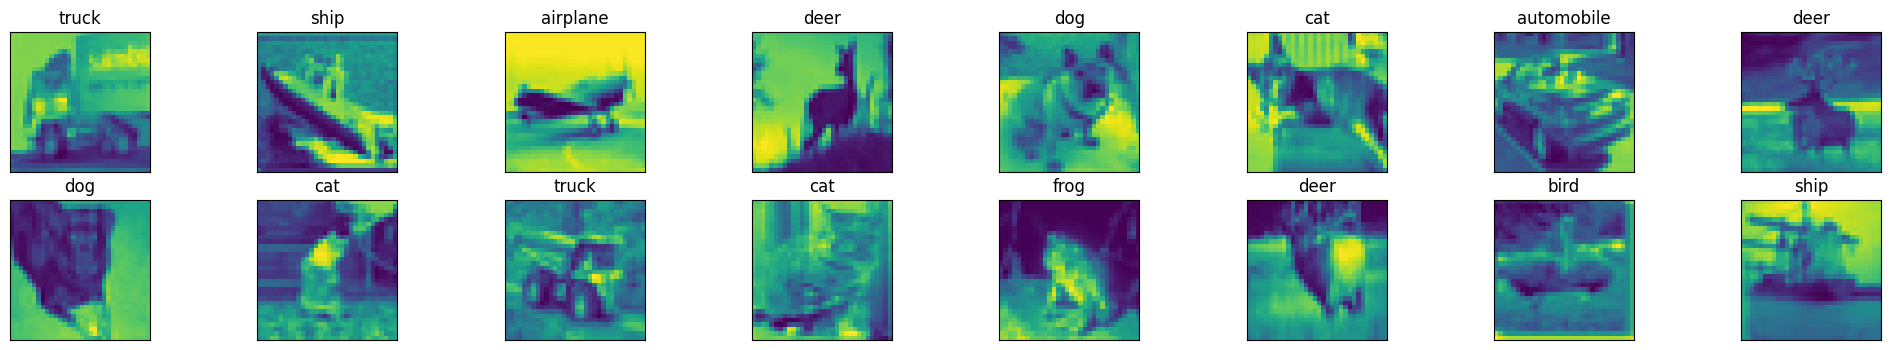

In [14]:
# obtaining one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# displaying images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx].item()])

**Defining Architecture of Lenet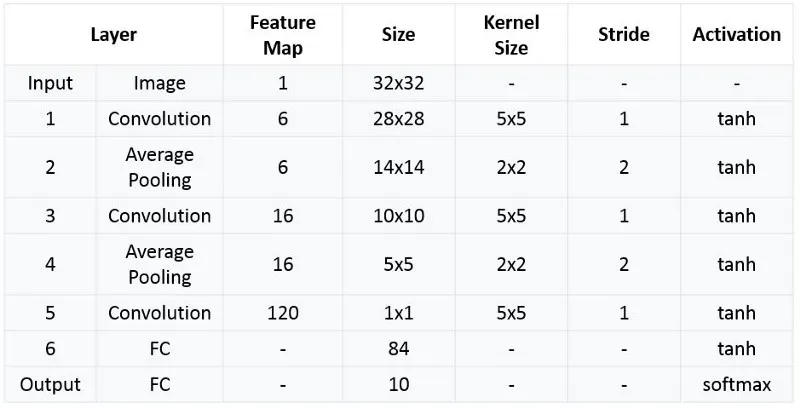**

In [16]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.Tanh())
        self.layer2 = nn.Sequential(
            nn.AvgPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.Tanh())
        self.layer4 = nn.Sequential(
            nn.AvgPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(400, 120),
            nn.Tanh()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.Tanh()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(84, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.flatten(start_dim=1)  # Flatten the output tensor
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

# Create an instance of the LeNet model
model = LeNet()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

LeNet(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
  )
  (layer2): Sequential(
    (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
  )
  (layer4): Sequential(
    (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
  )
  (fc3): Sequential(
    (0): Linear(in_features=84, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)


# Summary of model

In [17]:
summary(model, input_size = images.shape[1:], batch_size = 16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [16, 6, 28, 28]             156
       BatchNorm2d-2            [16, 6, 28, 28]              12
              Tanh-3            [16, 6, 28, 28]               0
         AvgPool2d-4            [16, 6, 14, 14]               0
            Conv2d-5           [16, 16, 10, 10]           2,416
       BatchNorm2d-6           [16, 16, 10, 10]              32
              Tanh-7           [16, 16, 10, 10]               0
         AvgPool2d-8             [16, 16, 5, 5]               0
            Linear-9                  [16, 120]          48,120
             Tanh-10                  [16, 120]               0
           Linear-11                   [16, 84]          10,164
             Tanh-12                   [16, 84]               0
           Linear-13                   [16, 10]             850
          Softmax-14                   

# Training the model

In [21]:
num_classes = 10
num_epochs = 20
batch_size = 64
# learning_rate = 0.01


if train_on_gpu:
  model = LeNet(num_classes).cuda()
else:
  model = LeNet(num_classes)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters())


# Train the model
total_step = len(train_loader)

In [ ]:
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the device
        if train_on_gpu:
          images = images.cuda()
          labels = labels.cuda()
        else:
          images = images
          labels = labels

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            if train_on_gpu:
              images = images.cuda()
              labels = labels.cuda()
            else:
              images = images
              labels = labels
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

Epoch [1/20], Step [2500/2500], Loss: 2.1526
Accuracy of the network on the 5000 validation images: 37.6 %
Epoch [2/20], Step [2500/2500], Loss: 2.0379
Accuracy of the network on the 5000 validation images: 39.27 %
Epoch [3/20], Step [2500/2500], Loss: 2.0826
Accuracy of the network on the 5000 validation images: 41.97 %
Epoch [4/20], Step [2500/2500], Loss: 2.1479
Accuracy of the network on the 5000 validation images: 43.67 %
Epoch [5/20], Step [2500/2500], Loss: 2.0106
Accuracy of the network on the 5000 validation images: 44.77 %
Epoch [6/20], Step [2500/2500], Loss: 1.8836
Accuracy of the network on the 5000 validation images: 45.07 %
Epoch [7/20], Step [2500/2500], Loss: 2.1053
Accuracy of the network on the 5000 validation images: 47.24 %
Epoch [8/20], Step [2500/2500], Loss: 1.8494
Accuracy of the network on the 5000 validation images: 46.49 %
Epoch [9/20], Step [2500/2500], Loss: 1.8786
Accuracy of the network on the 5000 validation images: 47.8 %
Epoch [10/20], Step [2500/2500

# Saving the model in .pt file

In [ ]:
torch.save(model.state_dict(), 'model-LeNet.pt')

In [ ]:
model.load_state_dict(torch.load('/content/model-LeNet.pt'))

# Finding accuracy of model

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

In [ ]:
model.load_state_dict(torch.load('/content/model-LeNet.pt'))

# Testing the model

In [ ]:
def evaluate(model, state_dict_file):

    model.load_state_dict(torch.load(state_dict_file))
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval()
    # iterate over test data
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)
        # update test loss
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(num_classes):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

evaluate(model, '/content/model-LeNet.pt')